In [1]:
import uproot as up
import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py
import os
import os.path
import time
import dill
import importlib
import sys

sys.path.insert(0, '/home/mark/work/DarkNu_Codebase_Nov2021/V4_2022/DarkNews-generator/examples')
sys.path.insert(0,'src/')

import DarkNews as dn
from DarkNews import const
from DarkNews.GenLauncher import GenLauncher
import ToyAnalysis.analysis_decay as an


#grab some local bits and bobs
from gLEE_tools import *
import MapBuilder as mb
import MasterTools as mst

#some additional info
uboone_vol=((0.55+254.8)*(115.53+117.47)*(0.1+1036.9))*1.3836*1e-6
print("Volume of MicroBooNE, ",uboone_vol) #-1.504115012818


Volume of MicroBooNE,  85.36524536346


# Closure Test, Load Master

In [2]:
#Give your data dircetory that various required gLEE ntuples are in
datadir ="datafiles_for_mapping/"
#create the masterHelper object with a unique tag for bookeeping. This is regardless of binning.
masterHelper = mst.MasterTools(datadir,"testM1")


Loading Master Oriringal files @  datafiles_for_mapping/
Loading Master Original FIles @  datafiles_for_mapping/
Loading master DataFrames from geenration
benchmark correction factors are:  1.1866690240452618 1.180029368575624 1.200214592274678 1.1828676470588235


#Check Higher and Lower "stats"

Text(0.5, 0, 'True Electron + Position Energy [GeV]')

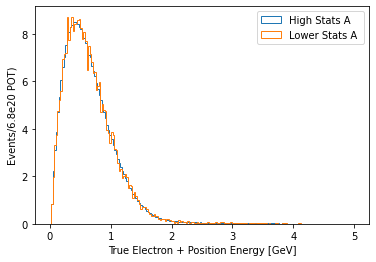

In [3]:
zz_bins=np.linspace(0, 5, 200)
plt.hist(masterHelper.df_A["P_decay_ell_plus"].values[:,0]+masterHelper.df_A["P_decay_ell_minus"].values[:,0],bins=zz_bins, weights=masterHelper.df_A["w_event_rate"].values,  histtype=u'step', label='High Stats A ');
plt.hist(masterHelper.df_A_low["P_decay_ell_plus"].values[:,0]+masterHelper.df_A_low["P_decay_ell_minus"].values[:,0],bins=zz_bins,weights=masterHelper.df_A_low["w_event_rate"].values, histtype=u'step', label='Lower Stats A ');
plt.legend()
#plt.yscale("log")
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('True Electron + Position Energy [GeV]')

#plt.hist(masterHelper.df_A["P_decay_ell_plus"].values[:,0]+masterHelper.df_A["P_decay_ell_minus"].values[:,0],bins=zz_bins, weights=np.full((masterHelper.df_A["P_decay_ell_plus"].values[:,0].size), 1)*masterHelper.df_A_low.shape[0]/masterHelper.df_A.shape[0],  histtype=u'step', label='High Stats A ');
#plt.hist(masterHelper.df_A_low["P_decay_ell_plus"].values[:,0]+masterHelper.df_A_low["P_decay_ell_minus"].values[:,0],bins=zz_bins, histtype=u'step', label='Lower Stats A ');
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('True Electron + Position Energy [GeV]')



# Closure test (Load Test Points)

In [4]:
#Raw vertexed files, no changes here
gLEE_TPA_vert = loadgLEE_Bare("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/MultiTop_Test_v4.0_FINAL_HOPE/SBNfit_files/vertex_DarkNu_Run1_Keystone_TestPointAlpha_noHF_v50.0.root")
gLEE_TPD_vert = loadgLEE_Bare("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/MultiTop_Test_v4.0_FINAL_HOPE/SBNfit_files/vertex_DarkNu_Run1_Keystone_TestPointDelta_noHF_v50.0.root")
gLEE_TPP_vert = loadgLEE_Bare("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/MultiTop_Test_v4.0_FINAL_HOPE/SBNfit_files/vertex_DarkNu_Run1_Keystone_TestPointPi_noHF_v50.0.root")
gLEE_TPG_vert = loadgLEE_Bare("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/MultiTop_Test_v4.0_FINAL_HOPE/SBNfit_files/vertex_DarkNu_Run1_Keystone_TestPointGamma_noHF_v50.0.root")

#v5.0 release stage 1 SBNfit files
gLEE_TPA_fin = loadgLEE("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/MultiTop_Release_v5.0_PostRME/sbnfitFiles/sbnfit_MultiTop_v5_0_stage_1_KeystoneTestPointAlpha_TextGen.root")
gLEE_TPD_fin = loadgLEE("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/MultiTop_Release_v5.0_PostRME/sbnfitFiles/sbnfit_MultiTop_v5_0_stage_1_KeystoneTestPointDelta_TextGen.root")
gLEE_TPP_fin = loadgLEE("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/MultiTop_Release_v5.0_PostRME/sbnfitFiles/sbnfit_MultiTop_v5_0_stage_1_KeystoneTestPointPi_TextGen.root")
gLEE_TPG_fin = loadgLEE("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/MultiTop_Release_v5.0_PostRME/sbnfitFiles/sbnfit_MultiTop_v5_0_stage_1_KeystoneTestPointGamma_TextGen.root")


In [5]:
df_TPAlpha = pd.read_pickle("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/Map_Develop/microboone_study/FilteredMapGeneration/Generate_TestPointAlphaDeltaPi_PC2023/TPAlpha_decayed_v4.pckl")
df_TPDelta = pd.read_pickle("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/Map_Develop/microboone_study/FilteredMapGeneration/Generate_TestPointAlphaDeltaPi_PC2023/TPDelta_decayed_v4.pckl")
df_TPPi = pd.read_pickle("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/Map_Develop/microboone_study/FilteredMapGeneration/Generate_TestPointAlphaDeltaPi_PC2023/TPPi_decayed_v4.pckl")
df_TPGamma = pd.read_pickle("/home/mark/work/DarkNu_Codebase_Nov2021/workin_dir/Map_Develop/microboone_study/FilteredMapGeneration/Generate_TestPointAlphaDeltaPi_PC2023/TPGamma_decayed_v4.pckl")

print("Alpha: ",df_TPAlpha.attrs['N5_ctau0'], df_TPAlpha['w_event_rate'].sum())
print("Delta: ",df_TPDelta.attrs['N5_ctau0'], df_TPDelta['w_event_rate'].sum())
print("Gamma: ",df_TPGamma.attrs['N5_ctau0'], df_TPGamma['w_event_rate'].sum())
print("Pi: ",df_TPPi.attrs['N5_ctau0'], df_TPPi['w_event_rate'].sum())

potf = 6.6/6.8
TPA_corr_factor = potf*df_TPAlpha.shape[0]/gLEE_TPA_vert.shape[0]
TPD_corr_factor = potf*df_TPDelta.shape[0]/gLEE_TPD_vert.shape[0]
TPP_corr_factor = potf*df_TPPi.shape[0]/gLEE_TPP_vert.shape[0]
TPG_corr_factor = potf*df_TPGamma.shape[0]/gLEE_TPG_vert.shape[0]
print(TPA_corr_factor,TPD_corr_factor,TPP_corr_factor,TPG_corr_factor)


Alpha:  1.341668736420315e-12 105.24487585077932
Delta:  32.74428544329297 109.78698168041419
Gamma:  117.19591325129653 131.45522235339035
Pi:  0.04481659598923676 142.37799453444083
0.9870490023777525 1.0337296049806786 1.0788781512605041 1.034172391584371


# Develop Binning

In [41]:
#Pick a simple 7 dim binning


simple_bins_energy_e_minus = [0., 10.]
simple_bins_energy_sum =  np.linspace(0,2,20)#20
simple_bins_energy_asym =  np.linspace(0,1,10)#10 works 
simple_bins_delta_theta = np.linspace(0,180,20)#20
simple_bins_pz_p_e_plus = [-1,  1.]
simple_bins_pz_p_e_minus = [-1, 1] #np.concatenate((np.linspace(-1, 0.5, 3,endpoint=True), np.linspace(0.55,1,20, endpoint=True)))
simple_bins_theta_sum =  [0, 180] #np.concatenate((np.linspace(0, 45, 20,endpoint=True), [180] ))
simple_bins_pos_decay_z = np.linspace(-520,520,4) #4 is best


simple_binning_scheme = (
    simple_bins_energy_e_minus,
    simple_bins_energy_sum,
    simple_bins_energy_asym,
    simple_bins_delta_theta, 
    simple_bins_pz_p_e_plus, 
    simple_bins_pz_p_e_minus,
    simple_bins_theta_sum,
    simple_bins_pos_decay_z
)

# Using this binning build master maps AND TestPoint Maps

In [42]:
#At this stage we assign the binning, and build the master maps. If you have them premade you can simply load them in the next line

masterHelper.closeMasterMap()
m_TPA.close()
m_TPG.close()
m_TPP.close()
m_TPD.close()


masterHelper.buildMasterMap(simple_binning_scheme, "datafiles_for_mapping/output_maps/")
masterHelper.loadMasterMap("datafiles_for_mapping/output_maps/")

#and Test Point Maps
map_TPD= mb.MapBuilder(df_TPDelta,df_TPDelta.shape[0])
map_TPD.run()
dir_tree = os.path.dirname("datafiles_for_mapping/output_maps/TPD_v2.hdf5")
os.makedirs(dir_tree, exist_ok=True)
map_TPD.build(binning_scheme=simple_binning_scheme, file_name="datafiles_for_mapping/output_maps/TPD_v2.hdf5")
m_TPD = h5py.File("datafiles_for_mapping/output_maps/TPD_v2.hdf5", "r")

if True:
    map_TPA= mb.MapBuilder(df_TPAlpha,df_TPAlpha.shape[0])
    map_TPA.run()
    dir_tree = os.path.dirname("datafiles_for_mapping/output_maps/TPA_v2.hdf5")
    os.makedirs(dir_tree, exist_ok=True)
    map_TPA.build(binning_scheme=simple_binning_scheme, file_name="datafiles_for_mapping/output_maps/TPA_v2.hdf5")
    m_TPA = h5py.File("datafiles_for_mapping/output_maps/TPA_v2.hdf5", "r")

    map_TPP= mb.MapBuilder(df_TPPi,df_TPPi.shape[0])
    map_TPP.run()
    dir_tree = os.path.dirname("datafiles_for_mapping/output_maps/TPP_v2.hdf5")
    os.makedirs(dir_tree, exist_ok=True)
    map_TPP.build(binning_scheme=simple_binning_scheme, file_name="datafiles_for_mapping/output_maps/TPP_v2.hdf5")
    m_TPP = h5py.File("datafiles_for_mapping/output_maps/TPP_v2.hdf5", "r")

    map_TPG= mb.MapBuilder(df_TPGamma,df_TPGamma.shape[0])
    map_TPG.run()
    dir_tree = os.path.dirname("datafiles_for_mapping/output_maps/TPG_v2.hdf5")
    os.makedirs(dir_tree, exist_ok=True)
    map_TPG.build(binning_scheme=simple_binning_scheme, file_name="datafiles_for_mapping/output_maps/TPG_v2.hdf5")
    m_TPG = h5py.File("datafiles_for_mapping/output_maps/TPG_v2.hdf5", "r")


Building map for testM1_BPA
output will be at  datafiles_for_mapping/output_maps//testM1_BPA.hdf5 starting on mapBuilder Constructor
run()
build hdf5
Including Weights
Done on  testM1_BPA
Building map for testM1_BPB
output will be at  datafiles_for_mapping/output_maps//testM1_BPB.hdf5 starting on mapBuilder Constructor
run()
build hdf5
Including Weights
Done on  testM1_BPB
Building map for testM1_BPC
output will be at  datafiles_for_mapping/output_maps//testM1_BPC.hdf5 starting on mapBuilder Constructor
run()
build hdf5
Including Weights
Done on  testM1_BPC
Building map for testM1_BPD
output will be at  datafiles_for_mapping/output_maps//testM1_BPD.hdf5 starting on mapBuilder Constructor
run()
build hdf5
Including Weights
Done on  testM1_BPD
loading master maps from  datafiles_for_mapping/output_maps/
Now available to helper as self.map_X
Including Weights
Including Weights
Including Weights
Including Weights


# Perform actual reweighing here


In [43]:
#As you ask for reweights, you populate the internal dataframe with new weights


masterHelper.reweight(m_TPP,"m2TPP")
masterHelper.reweight(m_TPA,"m2TPA")
masterHelper.reweight(m_TPG,"m2TPG")
result = masterHelper.reweight(m_TPD,"m2TPD")


Starting to reweight master map to target, weight name  m2TPP
Apply the map took  272.8478960990906
Some (possibly useful) info
Outside Binning:  0
Div by Zero:  0
Zero:  5381
Valid:  37852
Mean Non-zero Weight:  0.08425787701252137
Mean Weight:  0.07377071127791177
Starting to reweight master map to target, weight name  m2TPA
Apply the map took  304.5074517726898
Some (possibly useful) info
Outside Binning:  0
Div by Zero:  0
Zero:  27411
Valid:  15822
Mean Non-zero Weight:  0.22033016250871879
Mean Weight:  0.08063432635285428
Starting to reweight master map to target, weight name  m2TPG
Apply the map took  306.8298227787018
Some (possibly useful) info
Outside Binning:  0
Div by Zero:  0
Zero:  21125
Valid:  22108
Mean Non-zero Weight:  0.02886398083285089
Mean Weight:  0.014760134347666539
Starting to reweight master map to target, weight name  m2TPD
Apply the map took  298.94822692871094
Some (possibly useful) info
Outside Binning:  0
Div by Zero:  0
Zero:  4079
Valid:  39154
Mean 

# And Plot

In [44]:
def plotNorm(N2,N1,E2,E1,tag,col):
    # Data point coordinates
    x = [1]
    y = [N1]
    # Error values (you can replace these with your own error values)
    y_err = [E1]
    x2 = [2]
    y2 = [N2]
    # Error values (you can replace these with your own error values)
    y2_err = [E2]

    # Plotting the data point with error bars
    plt.errorbar(x, y, yerr=y_err, fmt='o', capsize=4, color=col,label= tag+" exact")
    plt.errorbar(x2, y2, yerr=y2_err, fmt='o', capsize=4, color='red', label='Master->' +tag+' Reweight')

    # Optional: Add labels and title to the plot
    plt.ylabel('Number of final events/ 6.8e20 POT')
    plt.title('Total Normalization')
    plt.gca().set_xticks([])
    plt.gca().set_xticklabels([])
    plt.legend(loc='lower right')
    plt.xlim(-1, 5)
    plt.ylim(np.min([N2,N1])*0.6,np.max([N2,N1])*1.2)

    # Display the plot
    plt.show()


def plotAll(glee_file, corr_factor, result, key, tag,col):

    TP_total = (corr_factor*glee_file["simple_weight"]*glee_file["pass_selection"]).sum()
    TP_reweight = (1.0*result[key]*result["pass_selection"]*result['true_weight']).sum()
    TP_total_err = np.sqrt(np.sum(np.square( (corr_factor*glee_file["simple_weight"]*glee_file["pass_selection"]).values)))
    TP_reweight_err = np.sqrt(np.sum(np.square((1.0*result[key]*result["pass_selection"]*result['true_weight']).values)))

    plotNorm(TP_reweight,TP_total, TP_reweight_err, TP_total_err, tag,col)
    print(tag," : ", TP_total, "ReWeight: ", TP_reweight)

    print("(Reweight-True)/True", np.absolute(TP_total-TP_reweight)/TP_total)


    plt.figure(figsize=(16, 12))  

    plt.subplot(2, 3, 1) 
    esum_bins=np.linspace(0, 2.0, 50)
    plt.hist(glee_file["reco_energy"]/1000.,bins=esum_bins, weights=corr_factor*glee_file["simple_weight"]*glee_file["pass_selection"], histtype=u'step', label=tag,color=col)
    plt.hist(result["reco_energy"]/1000.,bins=esum_bins, weights=1.0*result[key]*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> '+tag+' Reweight', color='red')
    plt.legend()
    plt.ylabel('Events/6.8e20 POT)')
    plt.xlabel('Reco Electron + Position Energy [GeV]')
    plt.subplot(2, 3, 2) 

    #plt.yscale('log')
    asym_bins=np.linspace(0, 1, 10)
    plt.hist(glee_file["true_energy_asym"],bins=asym_bins, weights=corr_factor*glee_file["simple_weight"]*glee_file["pass_selection"], histtype=u'step', label=tag, color=col)
    plt.hist(result["true_energy_asym"],bins=asym_bins, weights=1.0*result[key]*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> '+tag+' Reweight', color='red')
    plt.legend()
    plt.ylabel('Events/6.8e20 POT)')
    plt.xlabel('True energy Asymettry')
    #plt.yscale('log')

    plt.subplot(2, 3, 3) 
    theta_bins=np.linspace(0, 180, 50)
    plt.hist(glee_file["true_delta_theta"],bins=theta_bins, weights=corr_factor*glee_file["simple_weight"]*glee_file["pass_selection"], histtype=u'step', label=tag, color=col)
    plt.hist(result["true_delta_theta"],bins=theta_bins, weights=1.0*result[key]*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> '+tag+' Reweight', color='red' )
    plt.legend()
    plt.ylabel('Events/6.8e20 POT)')
    plt.xlabel('True e+e- opening angle [Deg]')
    #plt.yscale('log')

    plt.subplot(2, 3, 4) 
    zz_bins=np.linspace(0, 1200, 50)
    plt.hist(glee_file["true_vertex_z"],bins=zz_bins, weights=corr_factor*glee_file["simple_weight"]*glee_file["pass_selection"], histtype=u'step', label=tag, color=col)
    plt.hist(result["true_vertex_z"],bins=zz_bins, weights=1.0*result[key]*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> '+tag+' Reweight', color='red' )
    plt.legend()
    plt.ylabel('Events/6.8e20 POT)')
    plt.xlabel('True vertex pos Z [cm]')
    #plt.yscale('log')

    plt.subplot(2, 3, 5) 
    zz_bins=np.linspace(0, 180, 50)
    plt.hist(glee_file["true_theta_sum"],bins=zz_bins, weights=corr_factor*glee_file["simple_weight"]*glee_file["pass_selection"], histtype=u'step', label=tag,color=col)
    plt.hist(result["true_theta_sum"],bins=zz_bins, weights=1.0*result[key]*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> '+tag+' Reweight', color='red' )
    plt.legend()
    plt.ylabel('Events/6.8e20 POT)')
    plt.xlabel('true_theta_sum ')
    #plt.yscale('log')

    plt.subplot(2, 3, 6) 
    zz_bins=np.linspace(0, 2, 50)
    plt.hist(glee_file["true_energy_sum"],bins=zz_bins, weights=corr_factor*glee_file["simple_weight"]*glee_file["pass_selection"], histtype=u'step', label=tag, color=col)
    plt.hist(result["true_energy_sum"],bins=zz_bins, weights=1.0*result[key]*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> '+tag+' Reweight', color='red')
    plt.legend()
    plt.ylabel('Events/6.8e20 POT)')
    plt.xlabel('true enegry sum ')
    #plt.yscale('log')

    plt.tight_layout()

    plt.show()
    plt.savefig('Master_to_'+tag+'.pdf')  


In [10]:
result["true_weight"].sum()

1123.0724476503815

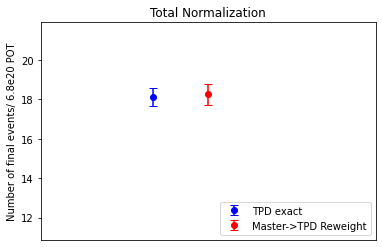

TPD  :  18.127845628162635 ReWeight:  18.24844897551156
(Reweight-True)/True 0.006652933273083565


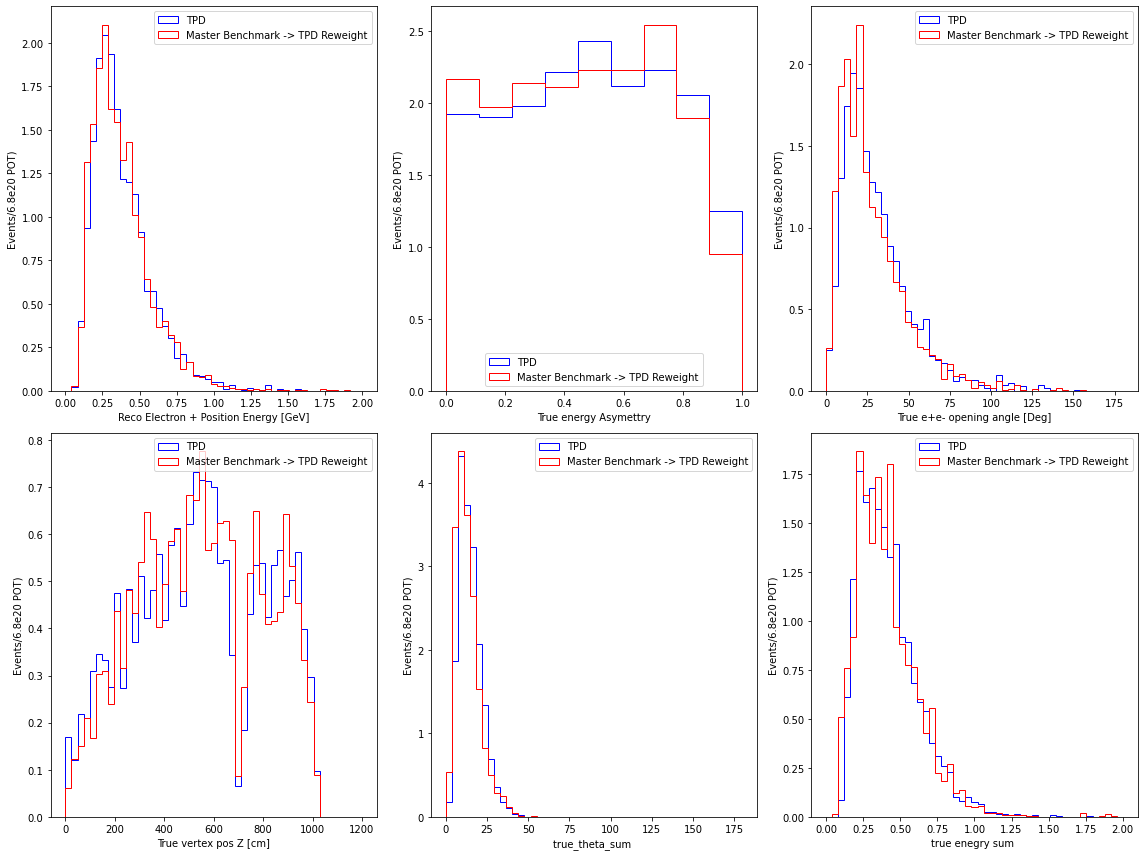

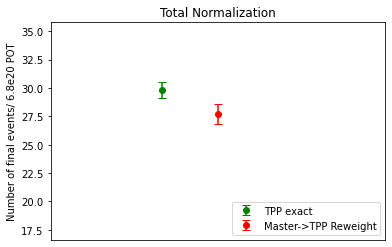

TPP  :  29.81615292547845 ReWeight:  27.702627325515298
(Reweight-True)/True 0.07088525489004667


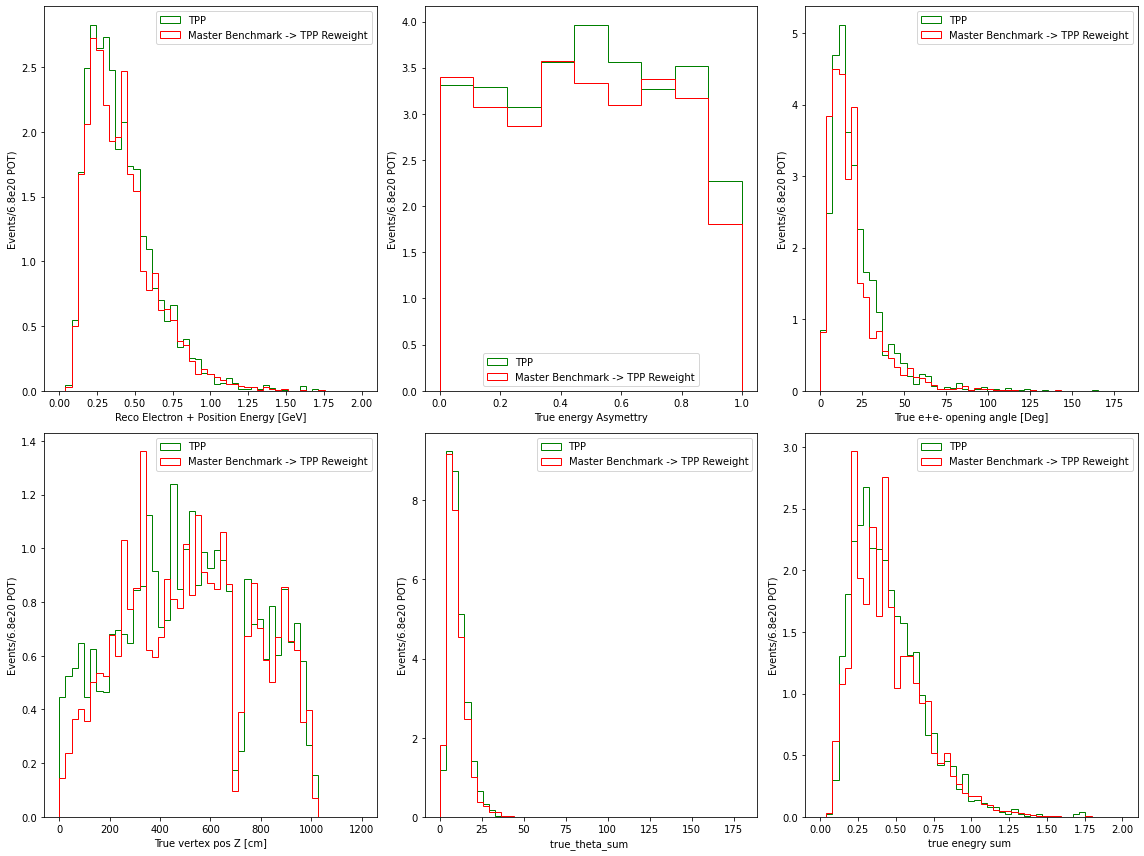

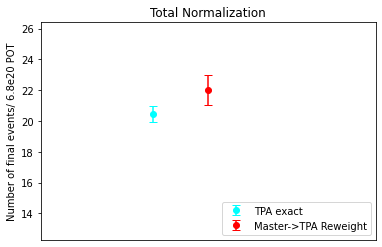

TPA  :  20.465665283052168 ReWeight:  22.007286739185805
(Reweight-True)/True 0.07532720949024167


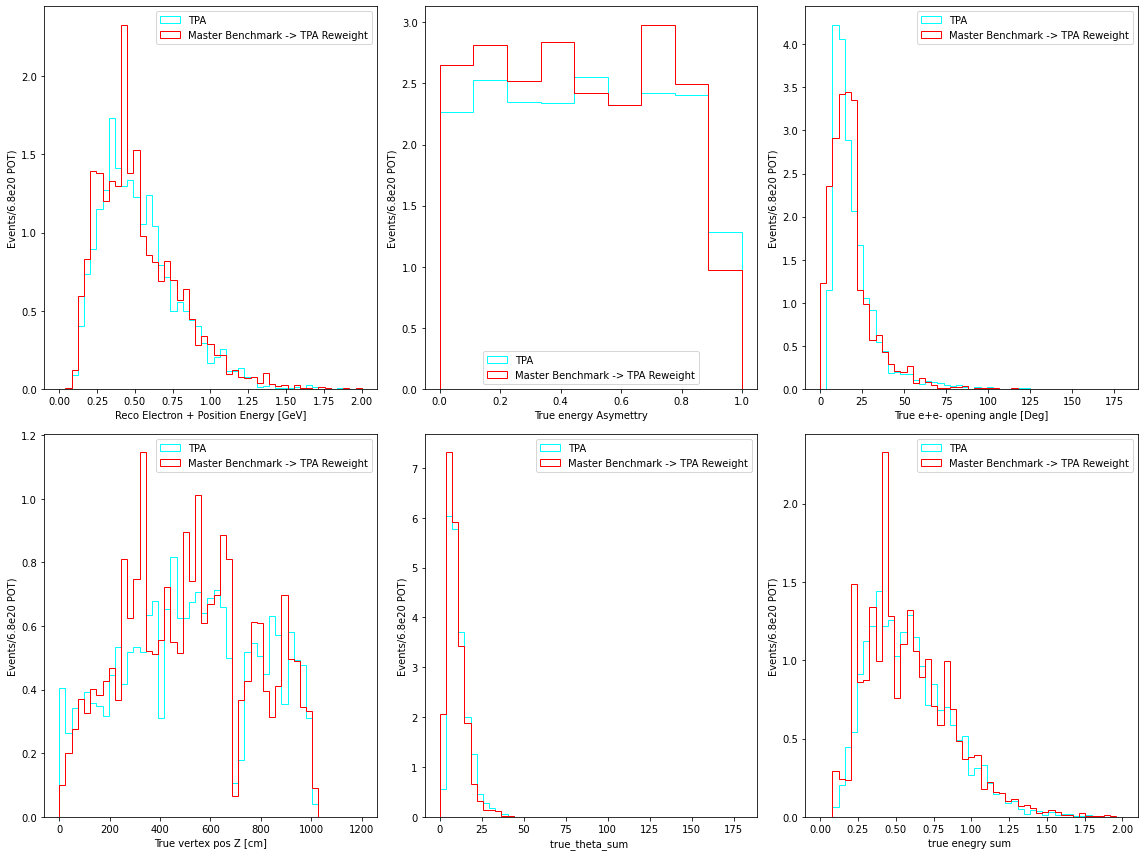

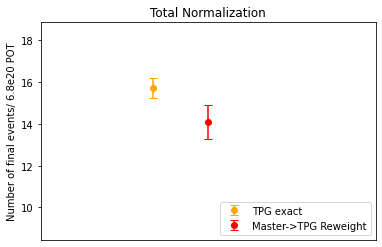

TPG  :  15.7182476530471 ReWeight:  14.085515980926589
(Reweight-True)/True 0.10387491711291331


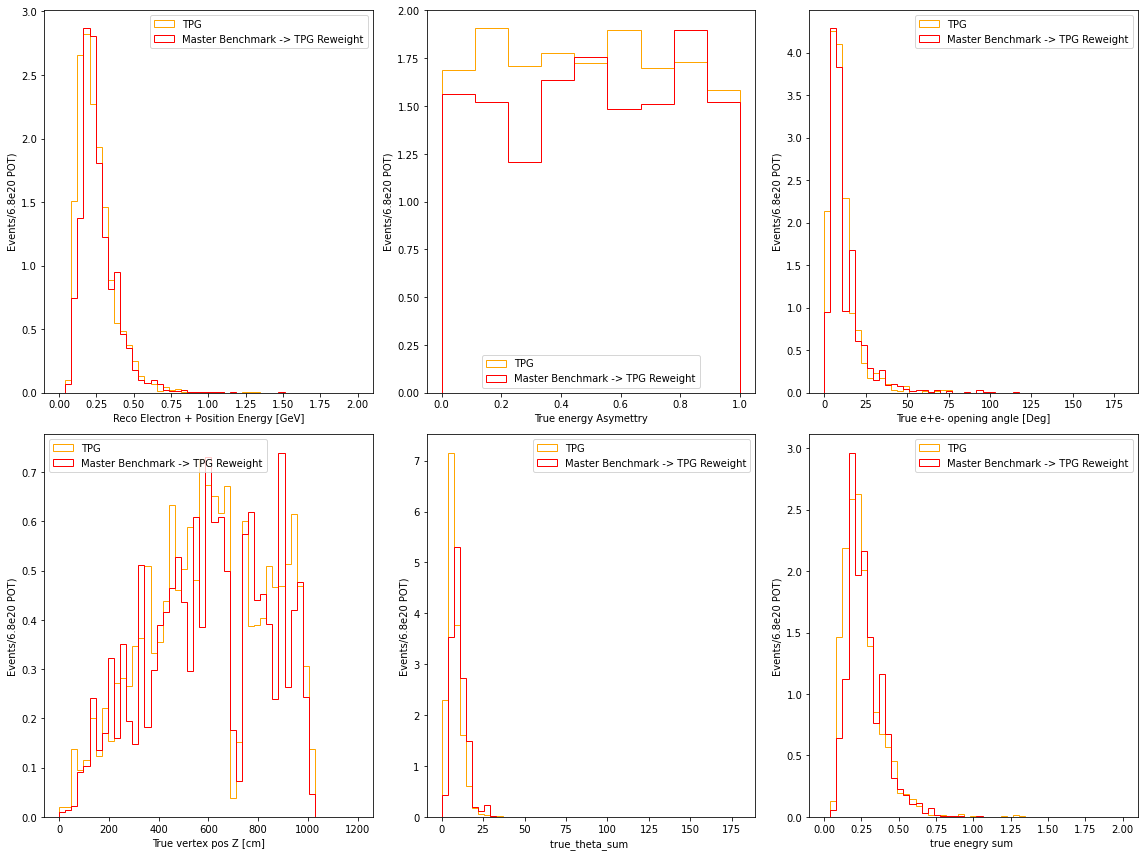

<Figure size 432x288 with 0 Axes>

In [45]:

%matplotlib inline
plotAll(gLEE_TPD_fin,TPD_corr_factor,result,"m2TPD","TPD",'blue')
plotAll(gLEE_TPP_fin,TPP_corr_factor,result,"m2TPP","TPP",'green')
plotAll(gLEE_TPA_fin,TPA_corr_factor,result,"m2TPA","TPA",'cyan')
plotAll(gLEE_TPG_fin,TPG_corr_factor,result,"m2TPG","TPG",'orange')



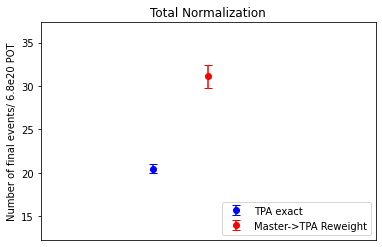

0.6577780259023827


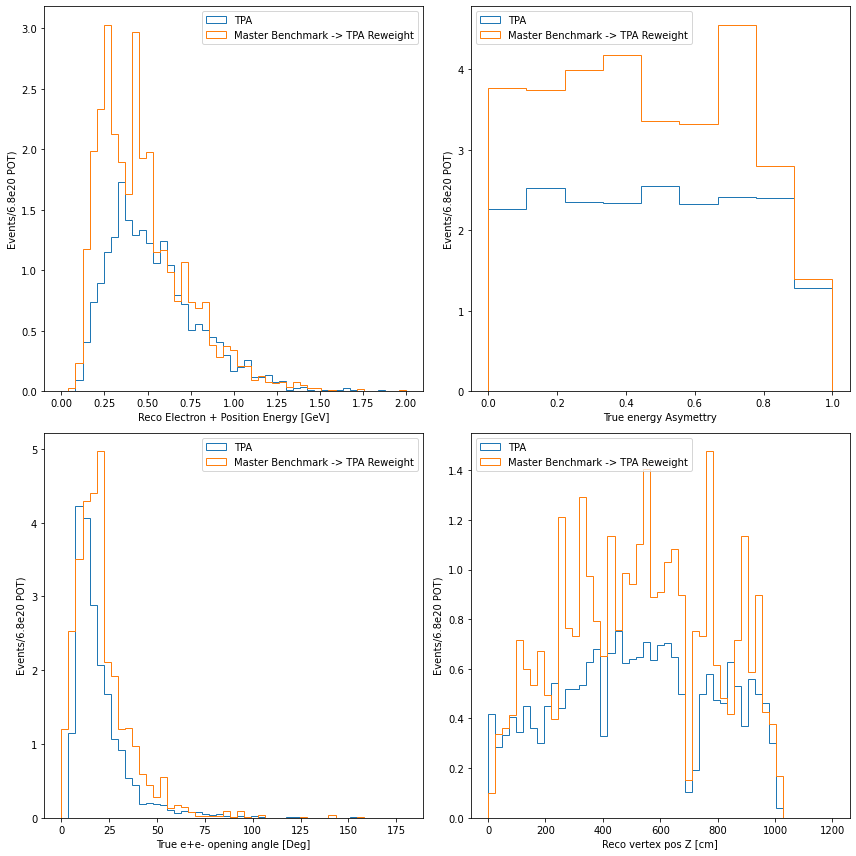

<Figure size 432x288 with 0 Axes>

In [12]:

%matplotlib inline


TPA_total = (TPA_corr_factor*gLEE_TPA_fin["simple_weight"]*gLEE_TPA_fin["pass_selection"]).sum()
TPA_reweight = (1.0*result['m2TPA']*result["pass_selection"]*result['true_weight']).sum()
TPA_total_err = np.sqrt(np.sum(np.square( (TPA_corr_factor*gLEE_TPA_fin["simple_weight"]*gLEE_TPA_fin["pass_selection"]).values)))
TPA_reweight_err = np.sqrt(np.sum(np.square((1.0*result['m2TPA']*result["pass_selection"]*result['true_weight']).values)))

plotNorm(TPA_reweight,TPA_total, TPA_reweight_err, TPA_total_err, "TPA")
print("TPA: ", TPA_total, "ReWeight: ", TPA_reweight)

print(TPA_total/TPA_reweight)


plt.figure(figsize=(12, 12))  

plt.subplot(2, 2, 1) 
esum_bins=np.linspace(0, 2.0, 50)
plt.hist(gLEE_TPA_fin["reco_energy"]/1000.,bins=esum_bins, weights=TPA_corr_factor*gLEE_TPA_fin["simple_weight"]*gLEE_TPA_fin["pass_selection"], histtype=u'step', label='TPA')
plt.hist(result["reco_energy"]/1000.,bins=esum_bins, weights=1.0*result['m2TPA']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPA Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('Reco Electron + Position Energy [GeV]')
plt.subplot(2, 2, 2) 

#plt.yscale('log')
asym_bins=np.linspace(0, 1, 10)
plt.hist(gLEE_TPA_fin["true_energy_asym"],bins=asym_bins, weights=TPA_corr_factor*gLEE_TPA_fin["simple_weight"]*gLEE_TPA_fin["pass_selection"], histtype=u'step', label='TPA')
plt.hist(result["true_energy_asym"],bins=asym_bins, weights=1.0*result['m2TPA']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPA Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('True energy Asymettry')
#plt.yscale('log')

plt.subplot(2, 2, 3) 
theta_bins=np.linspace(0, 180, 50)
plt.hist(gLEE_TPA_fin["true_delta_theta"],bins=theta_bins, weights=TPA_corr_factor*gLEE_TPA_fin["simple_weight"]*gLEE_TPA_fin["pass_selection"], histtype=u'step', label='TPA ')
plt.hist(result["true_delta_theta"],bins=theta_bins, weights=1.0*result['m2TPA']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPA Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('True e+e- opening angle [Deg]')
#plt.yscale('log')

plt.subplot(2, 2, 4) 
zz_bins=np.linspace(0, 1200, 50)
plt.hist(gLEE_TPA_fin["reco_vertex_z"],bins=zz_bins, weights=TPA_corr_factor*gLEE_TPA_fin["simple_weight"]*gLEE_TPA_fin["pass_selection"], histtype=u'step', label='TPA ')
plt.hist(result["reco_vertex_z"],bins=zz_bins, weights=1.0*result['m2TPA']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPA Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('Reco vertex pos Z [cm]')
#plt.yscale('log')

plt.tight_layout()

plt.show()
plt.savefig('Master_to_TPA.pdf')  


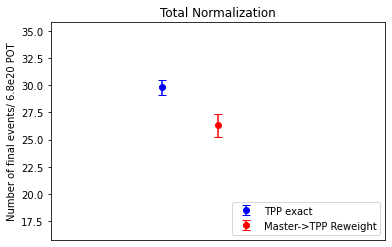

1.1335263619199551


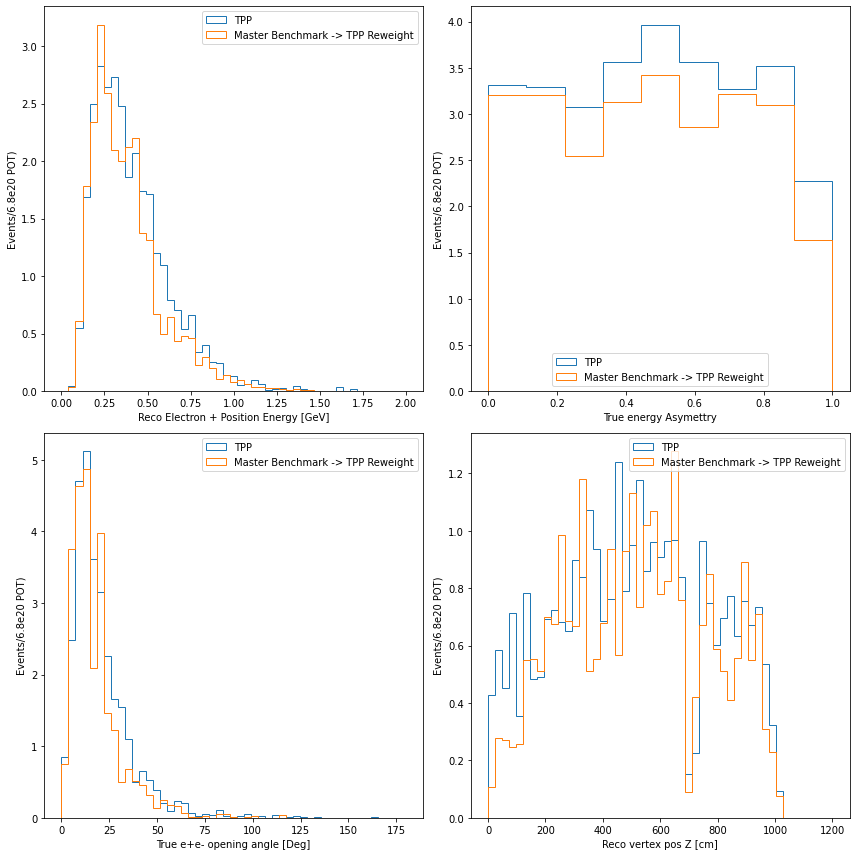

<Figure size 432x288 with 0 Axes>

In [13]:

%matplotlib inline


TPP_total = (TPP_corr_factor*gLEE_TPP_fin["simple_weight"]*gLEE_TPP_fin["pass_selection"]).sum()
TPP_reweight = (1.0*result['m2TPP']*result["pass_selection"]*result['true_weight']).sum()
TPP_total_err = np.sqrt(np.sum(np.square( (TPP_corr_factor*gLEE_TPP_fin["simple_weight"]*gLEE_TPP_fin["pass_selection"]).values)))
TPP_reweight_err = np.sqrt(np.sum(np.square((1.0*result['m2TPP']*result["pass_selection"]*result['true_weight']).values)))

plotNorm(TPP_reweight,TPP_total, TPP_reweight_err, TPP_total_err, "TPP")

print(TPP_total/TPP_reweight)


plt.figure(figsize=(12, 12))  

plt.subplot(2, 2, 1) 
esum_bins=np.linspace(0, 2.0, 50)
plt.hist(gLEE_TPP_fin["reco_energy"]/1000.,bins=esum_bins, weights=TPP_corr_factor*gLEE_TPP_fin["simple_weight"]*gLEE_TPP_fin["pass_selection"], histtype=u'step', label='TPP')
plt.hist(result["reco_energy"]/1000.,bins=esum_bins, weights=1.0*result['m2TPP']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPP Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('Reco Electron + Position Energy [GeV]')
plt.subplot(2, 2, 2) 

#plt.yscale('log')
asym_bins=np.linspace(0, 1, 10)
plt.hist(gLEE_TPP_fin["true_energy_asym"],bins=asym_bins, weights=TPP_corr_factor*gLEE_TPP_fin["simple_weight"]*gLEE_TPP_fin["pass_selection"], histtype=u'step', label='TPP')
plt.hist(result["true_energy_asym"],bins=asym_bins, weights=1.0*result['m2TPP']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPP Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('True energy Asymettry')
#plt.yscale('log')

plt.subplot(2, 2, 3) 
theta_bins=np.linspace(0, 180, 50)
plt.hist(gLEE_TPP_fin["true_delta_theta"],bins=theta_bins, weights=TPP_corr_factor*gLEE_TPP_fin["simple_weight"]*gLEE_TPP_fin["pass_selection"], histtype=u'step', label='TPP ')
plt.hist(result["true_delta_theta"],bins=theta_bins, weights=1.0*result['m2TPP']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPP Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('True e+e- opening angle [Deg]')
#plt.yscale('log')

plt.subplot(2, 2, 4) 
zz_bins=np.linspace(0, 1200, 50)
plt.hist(gLEE_TPP_fin["reco_vertex_z"],bins=zz_bins, weights=TPP_corr_factor*gLEE_TPP_fin["simple_weight"]*gLEE_TPP_fin["pass_selection"], histtype=u'step', label='TPP ')
plt.hist(result["reco_vertex_z"],bins=zz_bins, weights=1.0*result['m2TPP']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPP Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('Reco vertex pos Z [cm]')
#plt.yscale('log')

plt.tight_layout()

plt.show()
plt.savefig('Master_to_TPP.pdf')  


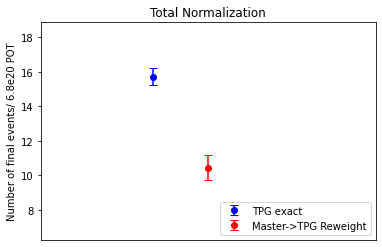

1.5026041169461952


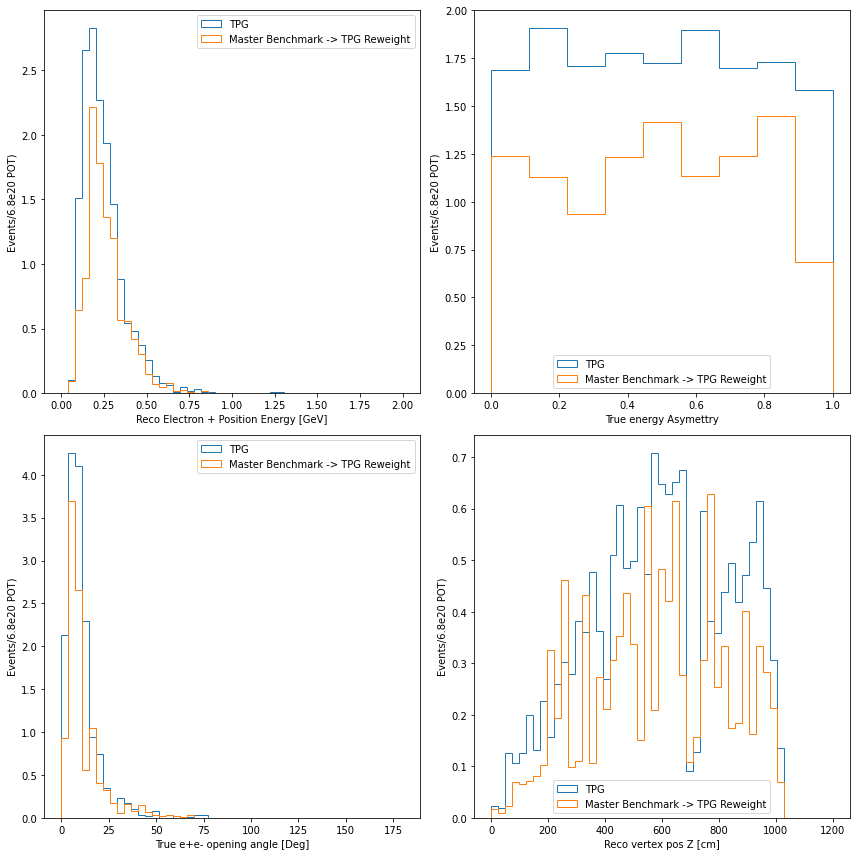

<Figure size 432x288 with 0 Axes>

In [14]:

%matplotlib inline


TPG_total = (TPG_corr_factor*gLEE_TPG_fin["simple_weight"]*gLEE_TPG_fin["pass_selection"]).sum()
TPG_reweight = (1.0*result['m2TPG']*result["pass_selection"]*result['true_weight']).sum()
TPG_total_err = np.sqrt(np.sum(np.square( (TPG_corr_factor*gLEE_TPG_fin["simple_weight"]*gLEE_TPG_fin["pass_selection"]).values)))
TPG_reweight_err = np.sqrt(np.sum(np.square((1.0*result['m2TPG']*result["pass_selection"]*result['true_weight']).values)))

plotNorm(TPG_reweight,TPG_total, TPG_reweight_err, TPG_total_err, "TPG")

#print(np.absolute(TPG_reweight-TPG_total)/(TPG_reweight+TPG_total)*100.)
print(TPG_total/TPG_reweight)


plt.figure(figsize=(12, 12))  

plt.subplot(2, 2, 1) 
esum_bins=np.linspace(0, 2.0, 50)
plt.hist(gLEE_TPG_fin["reco_energy"]/1000.,bins=esum_bins, weights=TPG_corr_factor*gLEE_TPG_fin["simple_weight"]*gLEE_TPG_fin["pass_selection"], histtype=u'step', label='TPG')
plt.hist(result["reco_energy"]/1000.,bins=esum_bins, weights=1.0*result['m2TPG']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPG Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('Reco Electron + Position Energy [GeV]')
plt.subplot(2, 2, 2) 

#plt.yscale('log')
asym_bins=np.linspace(0, 1, 10)
plt.hist(gLEE_TPG_fin["true_energy_asym"],bins=asym_bins, weights=TPG_corr_factor*gLEE_TPG_fin["simple_weight"]*gLEE_TPG_fin["pass_selection"], histtype=u'step', label='TPG')
plt.hist(result["true_energy_asym"],bins=asym_bins, weights=1.0*result['m2TPG']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPG Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('True energy Asymettry')
#plt.yscale('log')

plt.subplot(2, 2, 3) 
theta_bins=np.linspace(0, 180, 50)
plt.hist(gLEE_TPG_fin["true_delta_theta"],bins=theta_bins, weights=TPG_corr_factor*gLEE_TPG_fin["simple_weight"]*gLEE_TPG_fin["pass_selection"], histtype=u'step', label='TPG ')
plt.hist(result["true_delta_theta"],bins=theta_bins, weights=1.0*result['m2TPG']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPG Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('True e+e- opening angle [Deg]')
#plt.yscale('log')

plt.subplot(2, 2, 4) 
zz_bins=np.linspace(0, 1200, 50)
plt.hist(gLEE_TPG_fin["reco_vertex_z"],bins=zz_bins, weights=TPG_corr_factor*gLEE_TPG_fin["simple_weight"]*gLEE_TPG_fin["pass_selection"], histtype=u'step', label='TPG ')
plt.hist(result["reco_vertex_z"],bins=zz_bins, weights=1.0*result['m2TPG']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPG Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('Reco vertex pos Z [cm]')
#plt.yscale('log')

plt.tight_layout()

plt.show()
plt.savefig('Master_to_TPG.pdf')  


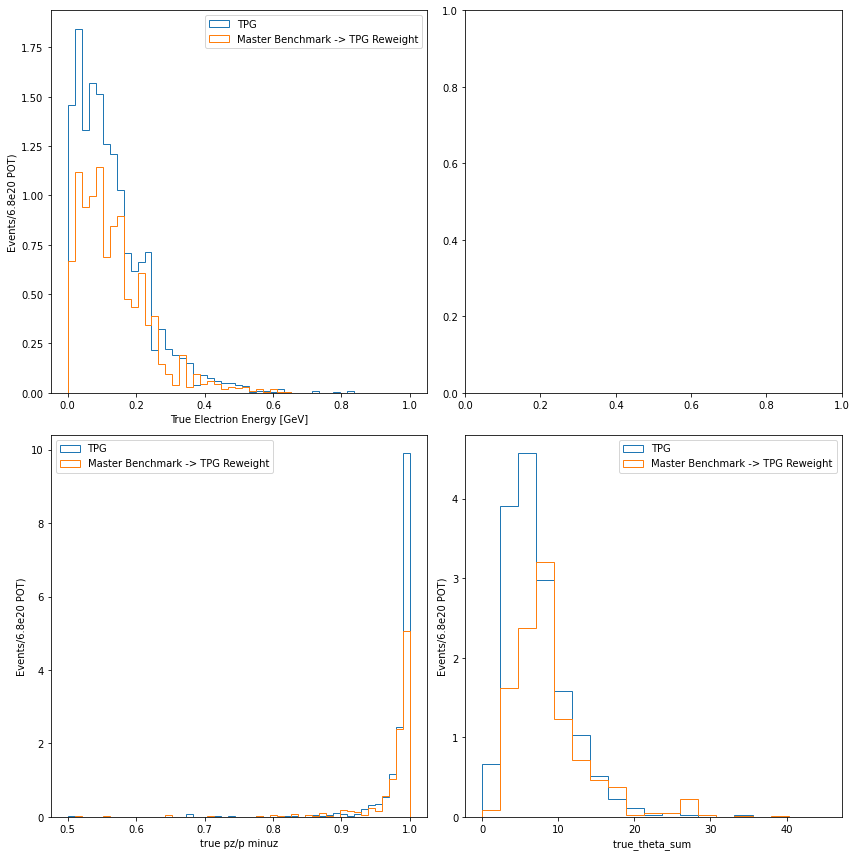

<Figure size 432x288 with 0 Axes>

In [17]:


plt.figure(figsize=(12, 12))  

plt.subplot(2, 2, 1) 
esum_bins=np.linspace(0, 1.0, 50)
plt.hist(gLEE_TPG_fin["true_energy_e_minus"],bins=esum_bins, weights=TPG_corr_factor*gLEE_TPG_fin["simple_weight"]*gLEE_TPG_fin["pass_selection"], histtype=u'step', label='TPG')
plt.hist(result["true_energy_e_minus"],bins=esum_bins, weights=1.0*result['m2TPG']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPG Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('True Electrion Energy [GeV]')
plt.subplot(2, 2, 2) 



plt.subplot(2, 2, 3) 
theta_bins=np.linspace(0.5, 1, 50)
plt.hist(gLEE_TPG_fin["true_pz_p_e_minus"],bins=theta_bins, weights=TPG_corr_factor*gLEE_TPG_fin["simple_weight"]*gLEE_TPG_fin["pass_selection"], histtype=u'step', label='TPG ')
plt.hist(result["true_pz_p_e_minus"],bins=theta_bins, weights=1.0*result['m2TPG']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPG Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('true pz/p minuz')
#plt.yscale('log')

plt.subplot(2, 2, 4) 
zz_bins=np.linspace(0,45,20)
plt.hist(gLEE_TPG_fin["true_theta_sum"],bins=zz_bins, weights=TPG_corr_factor*gLEE_TPG_fin["simple_weight"]*gLEE_TPG_fin["pass_selection"], histtype=u'step', label='TPG ')
plt.hist(result["true_theta_sum"],bins=zz_bins, weights=1.0*result['m2TPG']*result["pass_selection"]*result['true_weight'], histtype=u'step', label='Master Benchmark -> TPG Reweight' )
plt.legend()
plt.ylabel('Events/6.8e20 POT)')
plt.xlabel('true_theta_sum ')
#plt.yscale('log')

plt.tight_layout()

plt.show()
plt.savefig('Investigate_TPG.pdf')  